<a href="https://colab.research.google.com/github/Remydeme/Descarte/blob/master/20news_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install seaborn 
!pip install spacy 
!pip install pyldavis
!pip install bokeh
# download the vocab  
!pip3 install spacy
!python3 -m spacy download en_core_web_sm
!pip install tqdm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


# Introduction 

Le LDA  est un modèle de machine learning non supervisé, il permet d'associer un contexte à un document à partir des mots contenus dans ce document, lesquels pris individuellement pourraient appartenir à des contextes différents. 

Afin de tester l’algorithme nous avons travaillé sur le dataset “20newsGroup”. Ce jeu de données contient des textes à propos de 20 catégories différentes. 


In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    return out 
    


In [ ]:
news = twenty_newsgroup_to_csv()

# Dataset 

On peu supprimer les colonne inutile : 

* Unnamed: 0
* date 

In [ ]:
news = news[['text', 'target', 'title']]



* text : Le texte
* target : Nombre qui identifie la catégorie
* title : Titre donné à la catégorie  

## Distribution

Etudions la distribution des donnée par classes. 

In [ ]:
# Study the distribution 
import seaborn as sns 

distribution = news.title.value_counts()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
distribution = news.title.value_counts()
distribution = pd.DataFrame({'Category' : distribution.index, 'Frequency' : distribution.values})
distribution

,Category,Frequency
0,rec.sport.hockey,600
1,soc.religion.christian,599
2,rec.motorcycles,598
3,rec.sport.baseball,597
4,sci.crypt,595
5,sci.med,594
6,rec.autos,594
7,comp.windows.x,593
8,sci.space,593
9,comp.os.ms-windows.misc,591


In [ ]:
distribution.describe()

,Frequency
count,20.000000
mean,565.700000
std,58.251813
min,377.000000
25%,574.500000
50%,591.000000
75%,594.250000
max,600.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

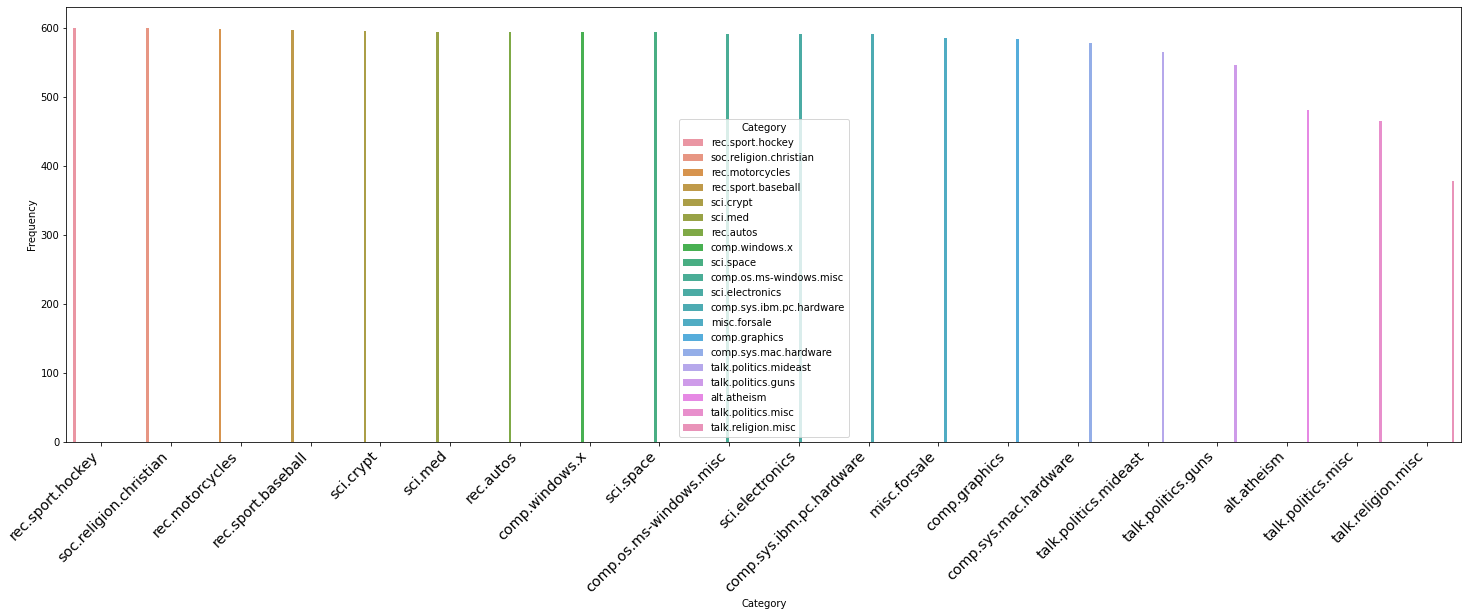

In [ ]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(25,8))
sns.barplot(y='Frequency', x='Category', data=distribution, hue='Category')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)


La distribution des articles est quasiment uniforme seul les classes religion, atheism, 
et politics sont sous représenté. La moyenne de textes par théme est de 565 et l'écart moyen des catégorie est de 58. Soit environ 10%. 


Analysons si il y a des valeur null

In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11314 entries, 0 to 11302
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   target  11314 non-null  object
 2   title   11314 non-null  object
dtypes: object(3)
memory usage: 353.6+ KB



On a 11096 textes et 11314 target ce qui signifie qu'il y a des textes vides .

In [ ]:
news.dropna(inplace=True)
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11314 entries, 0 to 11302
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   target  11314 non-null  object
 2   title   11314 non-null  object
dtypes: object(3)
memory usage: 353.6+ KB


### Etude du nombre de mot par texte 

Nous allons étudier la distribution du nombre de mots par textes. Puis nous supprimerons les texte ayant moins de 40. Le LDA a de mauvaises performances sur les articles court. Nous expliquerons pourquoi dans une analyse mathématique du fonctionnement de l'algorithme.  

In [ ]:
# count split the text into words 
array_of_article_words = []
for article in news.text.to_list():
  words = [word for word in article.split()]
  array_of_article_words.append(words)

In [ ]:
len(array_of_article_words)

11314

In [ ]:
news['tokenized'] = array_of_article_words

In [ ]:
news['doc_len'] = news['tokenized'].apply(lambda x: len(x))

In [ ]:
plt.figure(figsize=(9, 9))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
sns.countplot(x='doc_len', data=news)

In [ ]:
# only keep articles with more than 30 tokens, otherwise too short
news = news[news['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
news = news[news['tokenized'].map(type) == list]
news.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(news), "articles")

After cleaning and excluding short aticles, the dataframe now has: 8551 articles


# Préparation du texte 

Nous allons faire un nettoyage du texte. C'est un nettoyage permettant de remplacer les caractères spéciaux des urls et mails. 


In [ ]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    return df

In [ ]:
news = standardize_text(df=news, text_field='text')

## CounVectorizer 


Le CountVectorizer est une fonction qui va réaliser plusieurs actions : 

- Créer un vocabulaire à partir de notre texte
- Transformer notre collection de texte en token 
- Créer une représentation matriciel de chacun des mots du vocabulaire.
- Compter la fréquence d'apparition de chaque mot dans le texte.

Il retourne pour chaque mot une matrices :

- une matrice creuse représentant le mot


Avant d'appliquer le CountVectorizer sur le texte, nous allons faire une fonction qui va être appelée par le countVectorizer afin de réaliser le lemming ainsi que le passage en token comme nous le souhaitons. Les "Stop words" du vocabulaire anglais seront également retirés des textes ils représentent un bruit que l'on doit supprimer pour améliorer nos résultats. 










### Spacy 

spaCy est une bibliothèque open-source gratuite pour le traitement du langage naturel en Python. Il comprend NER, étiquetage POS, analyse de dépendance, vecteurs de mots et plus encore.

Nous allons importer spacy afin d'utiliser son tokenizer ainsi que ces listes de vocabulaire et de ponctuations. 

In [ ]:
import spacy
import en_core_web_sm

print(f'Spacy version {spacy.__version__}')
nlp = en_core_web_sm.load()
stop_words = spacy.lang.en.STOP_WORDS
punctuations = spacy.lang.punctuation.LIST_PUNCT

Spacy version 2.2.4


In [ ]:
noisy_words = ['pt', 'gq', 'ml', 'kn', 'si','pl','cx', 'sl', 'lj', 'mr', 'okz', 'nrhj', 'giz', 'pl', 'ax', 'qs', 'ww', 'mt', 'sy', 'sp', 'hz', 'ck', 'ck', 'uw', 'cx', 'jb', 'tt', 'pl', 'uw', 'cx', 'nhl', 'sl', 'pp']
def prepareText(text, punctuation=True, lemming=True, stop_word=True):
    """
    Prepare the text by removing punctuation, stop words and doing lemming 
    :param text: 
    :return: text 
    """     
    clean_text = nlp(text)
    
    #lowering word
    #lemming 
    # if words is pronoun don't apply lemming because spacy convert the words 
    # in "_PRON-" 
    if lemming == True:
        clean_text = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in clean_text]
    
    #remove stop words
    if stop_word == True:
        clean_text = [ word for word in clean_text if (word not in stop_words) ]
    # remove punctuation 
    if punctuation == True:
        clean_text = [word for word in clean_text if word.isalpha() ]
    
    #remove single char [b-Z] we only keep 'a'
    clean_text = [ word for word in clean_text if (len(word) != 1 and word != 'a') ]

    clean_text = [ word for word in clean_text if (word not in noisy_words)]


    return clean_text
   
   

In [ ]:
prepareText(text="Hello world this, z e e z d is some text sl !!!! full with ^ punctuations $$$$")

['hello', 'world', 'text', 'punctuation']

Testons notre fonction de nettoyage de donné  


On peut voir que la ponctuation a bien été supprimé ainsi que les "stops words" ici ("is" , "some" ).

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline


In [ ]:
vectorizer = CountVectorizer(tokenizer=prepareText)
lda = LatentDirichletAllocation(n_components=20)
pipeline = Pipeline([('vectorizer',vectorizer), ('lda',lda)])

In [ ]:
corpus = news.text.to_list()

In [ ]:
topic_analysis = pipeline.fit_transform(corpus)

La fonction suivante parcours notre dataframe. Applique le vectorizer sur chacun des textes, puis le lda. Le LDA retourne un tableau contenant des valeurs décimales. Ces valeurs décimales représentent l'importance qu'a joué une thème dans la génération du document. Chaque index réprésente donc un thème. 
La fonction argmax appliqué à la sortie du tableau de valeur retourne l'index du thème ayant le score le plus élevé. Et donc le thème ayant joué le rôle le plus important dans la génération du document. Cette index est alors utilisé pour récupérer les N premiers mots du thème ayant le score le plus élevé.

In [ ]:
import numpy as np
 
def extractTopicAndLoadInDataframe(key, lda_key, count_vect, dataFrame, lda, nb_words=5):
    """
    :param cv: countVectorizer that was applied on the documents 
    :param df: the dataframe that contains the data 
    :param lda: Latent derichlet allocation trained 
    :param nb_words: number of words by topic that you want to used
    :return: 
    """
    document_labels = []
    for i, text in enumerate(dataFrame[key]):
        text_vectorized = count_vect.transform([text]) # get vectorized text 
        index = np.argmax(lda.transform(text_vectorized)) # sort by 
        topic = lda.components_[index]
        topic_word_index = topic.argsort()[-nb_words:] # get the 5 best word index of the topic
        features = count_vect.get_feature_names()
        labels = []
        for j in topic_word_index:
            labels.append(features[j]) 
        document_labels.append(labels)
    dataFrame[lda_key] = document_labels

In [ ]:
extractTopicAndLoadInDataframe(key="text", lda_key='lda_words',count_vect=vectorizer, dataFrame=news, lda=lda, nb_words=10)

In [ ]:
categories = news.title.unique()
for category in categories:
  print(f'___________Words for category {category} _____________')
  print(((news[news['title'] == category]).head(5))['lda_words'])
  

Les résultats sont intéressants. On observe que les mots associés à chaque texte ont une sémantique correspondant à la catégories. Afin de voir l'éfficacité de notre modèle il nous faudrait vérifier le taux d'érreur commis par notre modèle pour chaque théme. Étant données que l'on dispose des vrais label de chaque texte cela est possible. 

 


Remarque:  

- Après avoir effectué un nettoyage du texte en supprimant les lettres seules ainsi que les mots n'ayant aucun sens selon moi. J'ai remarqué que la catégorie auto n'était plus détecté par le LDA.  

- On observe également qu'il reste énormément de mots à deux  lettres ou trois n'ayant aucun sens qui ajoute du bruit et empêche à notre modèle de détecter toutes les thèmes. 

## Calcul de la précision


Pour faire ce cacul il nous faut associé à chaque groupe de mots le thème correspondant. Mais avant cela nous devons vérifier que notre modèle a été capable de retrouvé les 20 thèmes de départ.

Premièrement nous allons associé à chaque groupe de mot le topic correspondant. Nous allons faire cette operation de manière séquentielle.

- Afficher l'ensemble de mots (thème) 20 mots par thème
- Associer l'un après l'autre les thème aux groupe de mots dans un tableau.

In [ ]:
NB_TOPICS = 20
NB_WORDS = 10
topics = {}
for index in range(NB_TOPICS):
  topic = pipeline['lda'] .components_[index] 
  topic_word_index = topic.argsort()[-NB_WORDS:] # N words that have the greater saliance
  # now that we have the words index we can use the vectorized_corpus to get the word
  features = pipeline['vectorizer'].get_feature_names()
  labels = []
  for word_index in topic_word_index:
      labels.append(features[word_index]) 
  topics[str(index)] = np.flip(labels)

In [ ]:
pd.DataFrame(topics)

Alors les index :
- [0].    => 
- [1]     => soc.religion.christian / talk.religion.misc 
- [2 ]    => category rec.sport.baseball
- [18]    => category rec.sport.hockey
- [7]     => comp.windows.x 
- [8]     => comp.os.ms-windows.misc
- [9]     => category talk.politics.guns
- [11].   => category talk.politics.misc
- [12].   => general 
- [13].   => rec.motorcycles
- [14].   => error 
- [15].   => 
- [17].   => 
- [3].    => talk.politics.mideast
- [4].    => comp.sys.ibm.pc.hardware
- [19].   => sci.med
- [16].   => sci.religion

- rec.motorcycles sci.med
  comp.graphics
  comp.sys.mac.hardware
  rec.autos

In [ ]:
NB_TOPICS = 20
NB_WORDS = 10
topics = {}
for index in range(NB_TOPICS):
  topic = lda.components_[index] 
  topic_word_index = topic.argsort()[-NB_WORDS:] # N words that have the greater saliance
  # now that we have the words index we can use the vectorized_corpus to get the word
  features = vectorizer.get_feature_names()
  labels = []
  for word_index in topic_word_index:
      labels.append(features[word_index]) 
  topics[str(index)] = labels

In [ ]:
def extractAndMatchTopic(dataframe, topics, field, labels_key):
    """
    :param df: the dataframe that contains the data 
    :param topics: dictionary that contains the words and as a key the topic name   
    :return: 
    """
    topics_matched = []
    for index in range(dataframe[field].size()):
      match = False 
      for theme in topics:
        labels = topics[theme]
        if labels == dataframe[labels_key][index]:
          topics_matched.append(theme)
          match = True
        if match == False:
          topics_matched.append("unknown")
        else:
          match = False 
    dataframe['detected_topic'] = topics_matched

        
        

## Test du LDA
Essayont maintenant de voir à quelle catégorie est associé un texte qui n'a pas encore été vu par notre modèle.

In [ ]:
def twenty_newsgroup_test():
    newsgroups_train = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    return out 

In [ ]:
test = twenty_newsgroup_test()

In [ ]:
test.info()

In [ ]:
test.target.value_counts()

In [ ]:
test.head()

In [ ]:
test_corpus = test.text.to_list()

In [ ]:
test_corpus = vectorizer.transform(test_corpus)

In [ ]:
test_result = lda.transform(test_corpus)

In [ ]:
extractTopicAndLoadInDataframe(key="text", lda_key='lda_words',count_vect=vectorizer, dataFrame=test, lda=lda, nb_words=10)

In [ ]:
test.head()

le modèle semble bien fonctionner, pour les catégorie auto le mot "car" est souvant dans la liste des mots associé au texte.

### Visualisation 

### pyLDAvis
pyLDAvis est conçu pour aider les utilisateurs à interpréter les thèmes dans un modèle de sujet adapté à un corpus de données textuelles. Le package extrait des informations d'un LDA pour fournir une visualisation Web interactive.


In [ ]:
import pyLDAvis.sklearn

In [ ]:

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, test_corpus, vectorizer, mds='tsne')
panel


Afin de classer les mots par importance le calcul de la sailliance est fait pour chaque mot : 

La saillance (de l'anglais salience) d'une chose quelconque est le fait qu'elle retienne l'attention ; plus précisément, la mesure dans laquelle elle retient l'attention par rapport aux autres choses présentes dans son environnement (y compris des choses similaires).

---

S(W) = frequency(w) * [sum p(t | w) * log (p(t | w) / p(t)]




- p(t | w) : la probabilité que le mot w appartienne au théme t 
- p(w | t) : la probabilité que le théme t génère le mot w 
- p(d | w)  : probabilité que le mot w appartienne au document w 


alpha = permet de classer les mots par pertinence un alpha de 1 signifie que le prévilégie la pertinence à la frequence d'apparition du terme dans le théme.



1. Plus le cercle de la topic est large plus celle ci est fréquent e dans le corpus 
2. Les cercle qui sont proches cela signifie que les sujets sont considérés comme étant proches.
3. Pour chaque sujet on peut voir la liste des 20 mots qui sont les plus représentatif est qui selon le LDA font que ce qu'un texte appartient a cette catégorie. 
4 . A quel point le mot est 


## LSA , TruncatedSVD


Comparons les résultats de ces modèles avec ceux du LDA

In [ ]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 20
test_corpus = test.text.to_list()
vectorizer = CountVectorizer(tokenizer=prepareText)
data_vectorized = vectorizer.fit_transform(test_corpus)

In [ ]:

# Build a Latent Dirichlet Allocation Modl
lda_model = LatentDirichletAllocation(NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 

In [ ]:

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=NUM_TOPICS)
nmf_Z = nmf_model.fit_transform(data_vectorized)
print(nmf_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 

In [ ]:

# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized)
print(lsi_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

In [ ]:
def print_topics(model, vectorizer, top_n=20):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(lda_model, vectorizer)
print("=" * 20)
 
print("NMF Model:")
print_topics(nmf_model, vectorizer)
print("=" * 20)
 
print("LSI Model:")
print_topics(lsi_model, vectorizer)
print("=" * 20)
 

**Voyons à quoi ressemble le premier document du corpus dans différents espaces de sujet gras**

In [ ]:
topic = 'rec.sport.hockey'
text = test[test.title == topic].iloc[10, 0]
vectorized_text = vectorizer.transform([text])
results = []
model = ["lda", "NMF", "lsi"]
label = [topic, topic, topic]
text = [text, text, text]
lda_result = (lda_model.transform(vectorized_text))[0]
nmf_result = (nmf_model.transform(vectorized_text))[0]
lsi_result = (lsi_model.transform(vectorized_text))[0]
results.append(lda_result)
results.append(nmf_result)
results.append(lsi_result)
results_df = pd.DataFrame({'Text' : text, 'Model' : model, 'results' : results, 'True label' : label})
print(f"LDA : {lda_result} \n\n LSI : {lsi_result} \n\n nmf : {nmf_result}")

In [ ]:
results_df.Text[0]

**Interprêter ces résultats ? ** 


Chacun de ces algorithmes essaie de comprendre quel est la contribution de chacun des sujet dans la génération du document. Ici le document à l'index 0. 

D'après le LDA 60% du document index 1 est généré par le thème 14 (index 13) et 17% par le thème 16 (index 15). Lorsque l'on regarde les 10 premier mots du thème ça correpond à des mots courant, on ne peut pas y associer un label. Le thème 16 en revanche, on peut lui affecter le label sport. ce serait donc un texte parlant principalement de sport. Ce qui correspond bien au label. 

On peut donc dire que le thème le plus représenté d'après le LDA n'est pas forcément le théme à affecter a un texte. 

Étudions les résultats du LSI. Selon le LSI le thème 3 joue un rôle important dans la génération de notre document. Si on regarde le thème 3 qui correspond à l'index 2, on peut associer ce thème à la religion. Ce thème ne correspond pas du tout à la catégorie de notre texte. Le thème 6 peut être associé au spécial ce qui ne correspond également pas.



Les résultats obtenus avec le NMF sont également incohérents. De plus, il est moins évident d'associer un label aux différents groupes de mots associé à chacun des thèmes.




Le LDA semble avoir de bien meilleurs résultats que les deux autres techniques. On ne peut pas l'affirmer, car nous avons seulement regardé les résultats pour un texte. Il faudrait le vérifier pour un grand échantillon de textes de chacune des catégories pris au hasard. Mais là n'est pas notre objectif.



LDA est la méthode la plus populaire pour la modélisation de sujets dans des applications réelles. En effet, il fournit des résultats précis, peut être entrainé en ligne. C'est à dire pas besoin d'entrainer de nouveau le modèle à chaque fois que nous obtenons de nouvelles données. Et peut être exécuté sur plusieurs cœurs. 

### Visualisation de nos articles et mots à l'aide du SVD

Le transformateur SVD effectue une réduction de dimensionnalité linéaire au moyen d'une décomposition de valeur singulière tronquée (SVD). Contrairement à l'ACP, cet estimateur ne centre pas les données avant de calculer la décomposition en valeurs singulières. Cela signifie qu'il peut fonctionner efficacement avec les matrices creuses.

In [ ]:
svd = TruncatedSVD(n_components=NUM_TOPICS)
documents_2d = svd.fit_transform(data_vectorized)
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(test_corpus))
 

In [ ]:

source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 

In [ ]:
plot = figure(plot_width=700, plot_height=700)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)


In [ ]:
svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(data_vectorized.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

A l'aide de l'algorithme du SVD nous avons reduit les dimensions de nos matrices creuses afin de représenter en deux dimensions les mots et les textes vectorizé. 

Le résultats est intéressant. La proximité entre des mots sur le graphique témoigne de leur proximité sémantiques.

On observe tout de même beaucoup de mot proche qui ne sont pas similaire sémantiquement.

Cela est dû à deux éléments :

- la quantité de texte n'est pas suffisante
- le countVectorizer ne capture pas le sens mais l'importance d'un mot dans un texte. Il retourne deux matrices. Une matrice représentant le mot et une matrice représantant la fréquence d'apparition de celui ci dans le texte (son importance).


## Étude de l'impacte de la distibution des données sur le LDA

A partir du dataset 20NewsGroup nous allons créer un échantillons de données non équilibré de texte. La manière correcte de le faire serait :

1.  Faire une fonction qui nous génére aléatoirement un pourcentage pour chaque théme 
2. Une fonction qui nous crée notre échantillons avec ce pourcentage.
3. Une fonction qui nous construit notre nouveau corpus de texte 

Nous allons faire une fonction qui va nous retourner un pourcentage pour chaque thème dans un tableau. 

In [ ]:
import random

def topicsDistribution(size):
  distribution = []
  for index in range(size):
    pourcentage = random.randrange(0, 100)
    distribution.append(pourcentage/100)
  return distribution

In [ ]:
def corpus(percentages, dataframe, field):
  counts = dataframe[field].value_counts()
  frequency_df = pd.DataFrame({'Category' : counts.index, 'Frequency' : counts.values})
  textCorpus = []
  for index in range(len(percentages)):
    #topic_size = frequency_df['Frequency'][index] * percentage
    percentage = percentages[index]
    topic_name = frequency_df['Category'][index] 
    texts = dataframe[dataframe.title == topic_name].sample(frac=percentage)
    textCorpus.append(texts)
  return pd.concat(textCorpus)

     



In [ ]:
def generateRandomDistribution(dataframe, field):
  size = len(dataframe[field].unique()) 
  percentages = topicsDistribution(size=size)
  corpus_df = corpus(percentages=percentages, dataframe=dataframe, field=field)
  return corpus_df 

In [ ]:
dist = generateRandomDistribution(dataframe=news, field='title')

Nous allons travailler sur 10 distributions aléatoire différentes.

In [ ]:
datasets = [ generateRandomDistribution(dataframe=news, field='title') for i in range(10)]

In [ ]:
def plotCat(distribution):
  plt.figure(figsize=(8,8))
  sns.barplot(y='Frequency', x='Category', data=distribution, hue='Category')
  plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
  )


In [ ]:
import matplotlib.pyplot as plt 

Maintenant appliquons notre LDA sur ces différentes distribution.

In [ ]:
analysis_results = []
corpus = test.text.to_list()
for index in range(len(datasets)):
  dataset = datasets[index]
  vectorizer = CountVectorizer(tokenizer=prepareText)
  lda = LatentDirichletAllocation(n_components=20)
  corpus = dataset.text.to_list()
  vectorized_corpus = vectorizer.fit_transform(corpus)
  result = lda.fit_transform(vectorized_corpus)
  analysis_results.append((corpus, vectorized_corpus, result, vectorizer, lda))

In [ ]:
  corpus, result, vectorizer, lda = analysis_results[0]
  vectorized_corpus = vectorizer.transform(corpus)

In [ ]:
  corpus, result, vectorizer, lda = analysis_results[0]
  vectorized_corpus = vectorizer.transform(corpus)

In [ ]:
import numpy as np
pyLDAvis.enable_notebook()
panels = []
for corpus, vectorized_corpus, result, vectorizer, lda in analysis_results:
  panel = pyLDAvis.sklearn.prepare(lda, vectorized_corpus, vectorizer, mds='tsne')
  panels.append(panel)

Fonction d'affichage de distribution 

In [ ]:
def distPlot(dataset, field='title'):    
  distribution = dataset[field].value_counts()
  distribution = pd.DataFrame({'Category' : distribution.index, 'Frequency' : distribution.values})
  plt.figure(figsize=(8,8))
  sns.barplot(y='Frequency', x='Category', data=distribution, hue='Category')
  plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
  )

In [ ]:
distPlot(dataset=datasets[0], field='title')

In [ ]:
datasets[0].title.value_counts().describe()

In [ ]:
panels[0]

In [ ]:
distPlot(dataset=datasets[1], field='title')

In [ ]:
datasets[1].title.value_counts().describe()

In [ ]:
panels[1]

In [ ]:
distPlot(dataset=datasets[2], field='title')

In [ ]:
datasets[2].title.value_counts().describe()

In [ ]:
panels[2]

In [ ]:
distPlot(dataset=datasets[3], field='title')

In [ ]:
datasets[3].title.value_counts().describe()

In [ ]:
panels[3]

In [ ]:
distPlot(dataset=datasets[4], field='title')

In [ ]:
datasets[4].title.value_counts().describe()

In [ ]:
panels[4]

Étudions l'évolution d'une topic en particulier en fonction de la distribution. 
On choisit d'étudier le théme automobile. 

On rappel que pyLDAvis permet d'observer les K topics que le LDA à determinés.
Les topics correspondent à un groupe de mots representant un théme **t**.

Dans le premier plot on peut observer que que la sphére 14 contient des mots dont la sémentique est celle de l'automobile. On peut donc dire que ce théme est bien détecté par le LDA. Dans les deux premiers plot le LDA a été entrainé des textes sur le topic de l'automobile dont la fréquence moyenne était de 400 textes. Lorsque la quantité de texte sur le thème de l'automobile est inférieur à 100 textes. On observe sur le plot qu'aucune sphére ne contient un ensemble de mots que l'on peut associé à l'automobile. On observe en revanche ces mots répartie dans différents thème.

On peut donc dire que lorsqu'un théme est sous représenté (frequence des textes du théme faible) il est difficile au LDA de détecter ce théme. Ce qui est mathématiquementlogique étant donné que la fréquence des mots associé à ce théme diminue. En effet, si la fréquence des mots associé au théme diminue la salliance des mots de ce même thème diminue. 

# Conclusion

Afin de faire de la labéllisation de texte à l'aide du LDA, il nous faudra entrainer le modèle sur un de grand volume de données de différentes catégorie avec un dataset dont l'écart-type de la taille des catégories est faible. 